# Stock Market Tweet Analysis


# Introduction

The stock market is arguably one of the most competitive environment, and every trader and institution is trying to gain an edge in this algorithmic arms race. Even though algorithmic trading computers have taken over the trading floors and now account for the majority of trades on the stock market, human psychology plays an important role in the market's movements. Stock market data is widely available and used for trading, however there are massive quantities of qualitative text data that has great influence over the market. In this project, our goal is to collect a data set of stock tweets and train a model to quantify sentiment on a given opinion about the stock market.

# Methodology

What we're trying to do is classify a given tweet as either bullish or bearish. *Bullish* meaning they think the stock is going up, *bearish* meaning they it's going down. The type of problem we are trying to solve is text classification.


This project is comprised of 4 parts:
1. Collecting a data set and understanding potential bias
2. Loading, cleaning, and embedding data
3. Initializing the model
4. Training and Evaluating the model

In [1]:
# One does not simply live without these
import re
import os
import time
import numpy as np
import pandas as pd
import random
import string
import torch
import matplotlib.pyplot as plt

In [2]:
# Configure GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print("GPU")
else:
    print("CPU")
    device = torch.device("cpu")

GPU


In [3]:
# seed random values
seed_val = 2020
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT Model

In this project, we are finetuning the robust NLP model, BERT. BERT is a transformer model developed by Google in 2018. To our benefit, the awesome people over at <a href="https://github.com/huggingface">Hugging Face</a> have made NLP a little bit easier for us. Their `transformers` library allows us to download the BERT model and use it with PyTorch. They also have many handy utilities to encode our data for the model. We'll be finetuning the BERT model with one additional output layer for binary classification.

During this project, we have tested several different models. The `transformers` library makes it easy to specify and change which pre-trained model we are using. During our testing, we found that distilBERT offered the best performance and accuracy. 

More models can be found <a href="https://huggingface.co/models">here</a>

In [4]:
from transformers import AutoConfig

# Configuring model for later

model_name = "distilbert-base-uncased"
# model_name = "bert-based-cased"
# model_name = "bert-large-cased"
# model_name = "bert-base-uncased"
# model_name = "bert-large-uncased"
# model_name = "xlnet-base-cased"
# model_name = "sshleifer/tiny-distilbert-base-uncased-finetuned-sst-2-english"
# model_name = "ipuneetrathore/bert-base-cased-finetuned-finBERT"

config = AutoConfig.from_pretrained(model_name,
                                    output_attentions = False,
                                    output_hidden_states = False,
                                    num_labels = 2, # binary classification
                                   )

# Collecting a data set

In order to collect a data set, we are using Stocktwits' API. Stocktwits is a wrapper on top of Twitter for stock market related information. Stocktwits allows for users to tweet on their platform and mark their opinion as either bullish or bearish on the stock.


![tmp/trump.png](tmp/trump.png)

In [5]:
'''
import pymysql

connection = pymysql.connect(user="admin_admin", password='*****',
                              host='*****',
                              database='admin_nlp_tweets')

db_cursor = connection.cursor()
db_cursor.execute('SELECT * FROM tweets')

table_rows = db_cursor.fetchall()

df = pd.DataFrame(table_rows)
'''

'\nimport pymysql\n\nconnection = pymysql.connect(user="admin_admin", password=\'E8Mv0oVq2f\',\n                              host=\'35.211.184.200\',\n                              database=\'admin_nlp_tweets\')\n\ndb_cursor = connection.cursor()\ndb_cursor.execute(\'SELECT * FROM tweets\')\n\ntable_rows = db_cursor.fetchall()\n\ndf = pd.DataFrame(table_rows)\n'

In [6]:
data_file_name = "data/1.5M_tweets.csv"
#df.to_csv(data_file_name, index=False)

df = pd.read_csv(data_file_name)

df = df.rename(columns={"2" : "tweets", "3" : "label"})

# make labels class integers
df["label"] = [1 if x == "Bullish" else 0 for x in df["label"]]

df.head()

,0,1,tweets,label,4,5
0,1,LPX,wkhs exc race bld lpx are hot today Weeeee,1,1,2020-11-04 04:54:30
1,2,LPX,WBT arnings lays ue m after ours ainers 6 55 6...,1,1,2020-11-04 04:54:30
2,3,LPX,LPX hopefully after earnings it explodes,1,1,2020-11-04 04:54:30
3,4,LPX,LPX,1,1,2020-11-04 04:54:30
4,5,LPX,LPX LPX Long Bullish will this see 32 52 by De...,1,2,2020-11-04 04:54:31


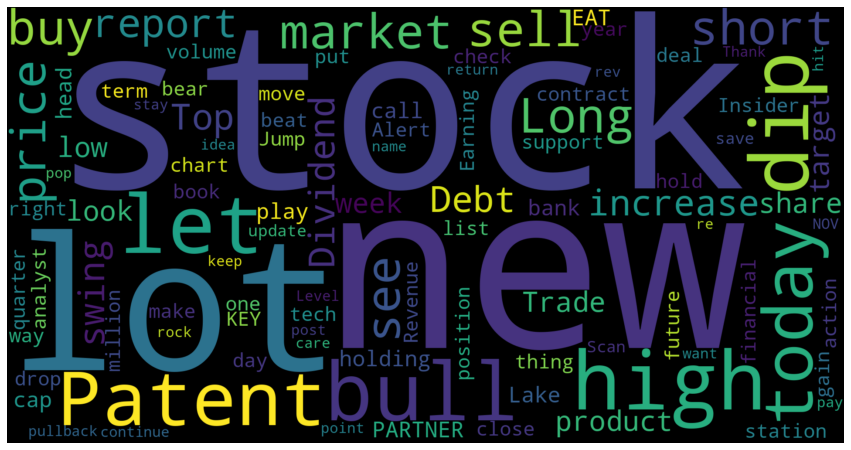

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# make vocabulary
vocab = {}

for i, row in df.iterrows():
    words = row["tweets"].split(" ")
    for w in words:
        if w not in vocab:
            vocab[w] = 1
        else:
            vocab[w] += 1

        
with open("data/vocab.txt", "w") as f:
    for v in vocab:
        f.write(v+"\n")

vocab_len = len(vocab)

# Sample 10k words in vocab
words = " "
i = 0
for v in vocab:
    i += 1
    if i > 10000:
        break
    words += v + " "

# generate wordcloud
wordcloud = WordCloud(max_words=100, height=1000, width=1920).generate(words)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

### Addressing Possible Sources of Bias in our Data

The platform also allows users to embed *cashtags* which are like hashtags except for stock symbols. For example $AAPL would link to Apple's stock. However, this presents a problem, as a given stock could introduce a bias into the data.

Let's say a stock like Tesla is overwhelmingly bullish, then the model might weight the token "\\$TSLA" with extreme positivity. Then, a tweet such as "$TSLA is gonna crash!" might be classified as bullish by our model.

## Data Cleaning
- Drop short tweets
- Replace "Bullish" and "Bearish" with 1 and 0 respectively
- Drop duplicate values
- Balance data set

In [8]:
def clean_tweet(tweet):
    # remove twitter syntax
    tweet = re.sub("RT @[\w]*:","",tweet)
    tweet = re.sub("@[\w]*","",tweet)
    tweet = re.sub("https?://[A-Za-z0-9./]*","",tweet)
    tweet = re.sub("\n","",tweet)
    
    return tweet

In [9]:
raw_len = len(df)

# clean tweets
df["tweets"] = [clean_tweet(t) for t in df["tweets"]]

# drop short tweets
short_tweets = []
for i, row in df.iterrows():
    tweet = row["tweets"]
    tweet_len = len(tweet.split(" "))
    if tweet_len < 5:
        short_tweets.append(i)

df = df.drop(short_tweets)

# only take unique tweets
df = df.drop_duplicates()

# drop any rows with null values
df = df.dropna()

# balance data
balance = np.sum(df["label"]) / len(df)
starting_balance = balance

while balance >= .51:
    index = df.index.values
    num_to_del = int((balance - .5) * len(df))
    del_tweets_index = []

    # count number of deleted tweets
    k = 0
    i = 0
    while k < num_to_del:
        idx = index[i]
        if df["label"][idx] == 1:
            del_tweets_index.append(idx)
            k += 1
        i += 1

    df = df.drop(del_tweets_index)
    balance = np.sum(df["label"]) / len(df)


print("Starting data balance: {:.2f}% positive".format(starting_balance))

balance = np.sum(df["label"]) / len(df)
print("New data balance: {:.2f}% positive".format(balance))

print("Raw data set length: ", raw_len)
print("Cleaned data set length: ", len(df))

Starting data balance: 0.83% positive
New data balance: 0.51% positive
Raw data set length:  1558602
Cleaned data set length:  458740


# Encoding Data for BERT

The model being used in this project is BERT.

- Add "[CLS]" at the beginning of each section and "[SEP]" at the end of every sentence
- Lowercase and tokenize each 
- Represent each token using an ID
- Pad or Truncate sequences to a fixed length
- Create corresponding attention masks for each input

BERT Tokenizer
https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer

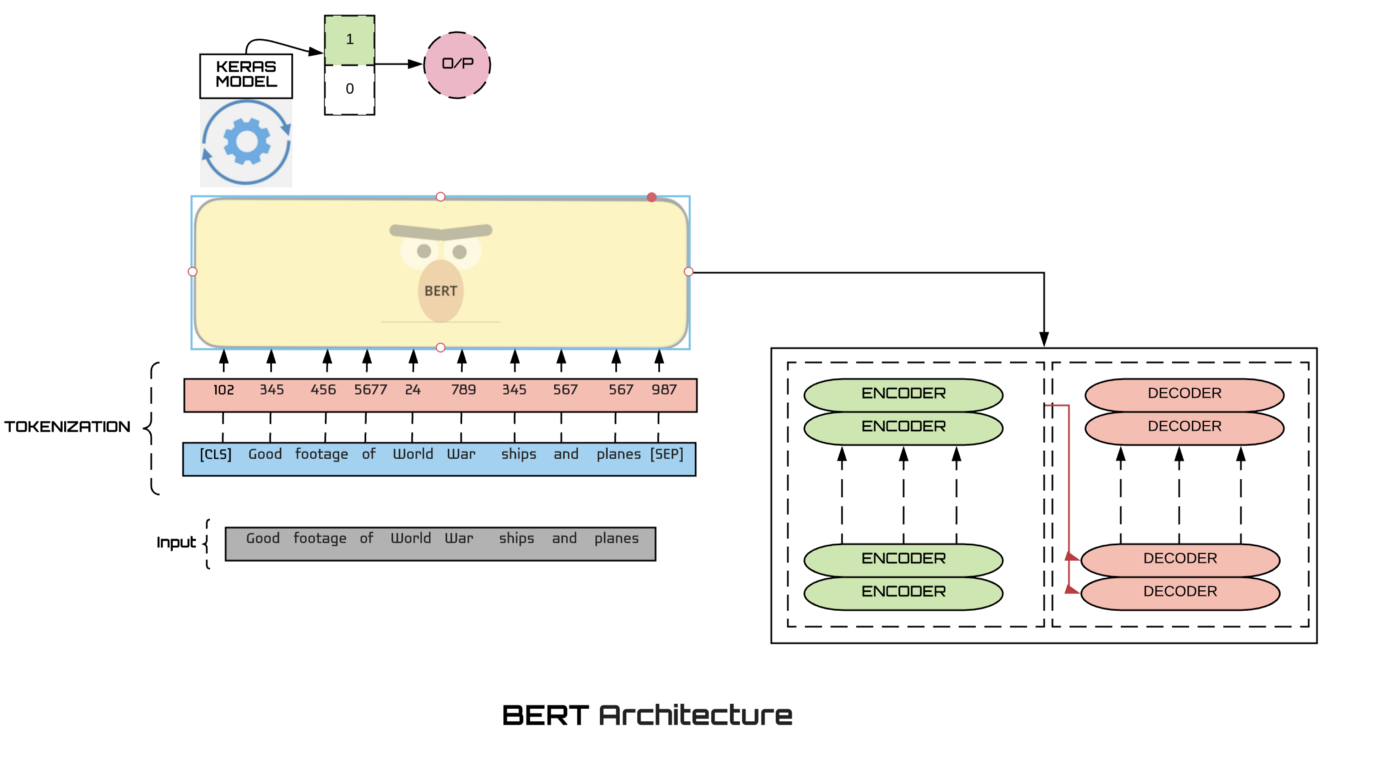

Original string: "this is a tweet"

Tokenized string: \["\[CLS]", "this", "is", "a", "tweet", "\[SEP\]"\]

Input IDs: \[15, 45, 56, 21, 194, 24\]

Padded string: \[15, 45, 56, 21, 194, 24, 0, 0, ...\]

Attention mask: \[1, 1, 1, 1, 1, 1, 0, 0, ...\]

In [10]:
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# take dataframe columns as lists
tweets = df.tweets.values
labels = df.label.values
    
def embed_text(tweets):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize words and map to IDs
    input_ids = []

    for tweet in tweets:
        encoded_tweet = tokenizer.encode(
                            tweet,
                            add_special_tokens = True,
                        )

        input_ids.append(encoded_tweet)
    
    max_len = 64

    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    # Create attention masks
    attention_masks = []

    # Iterate through tweet word IDs
    for i in input_ids:
        # Create a mask for each tweet
        # 1 if there's a word ID
        # 0 if ID is 0
        mask = [int(token_id > 0) for token_id in i]
        attention_masks.append(mask)
    
    return input_ids, attention_masks

In [11]:
input_ids, attention_masks = embed_text(tweets)

## Preparing Data for Model
- Divide data set into 90/10 train-test split
- Convert data to PyTorch tensors
- Load training and validation data into PyTorch dataloader

In [12]:
from sklearn.model_selection import train_test_split

# 90/10 Train-test split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
# Split attention masks too
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2020, test_size=0.1)

In [13]:
# Convert all inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 256

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Training the Model

- Load in model from Hugging Face's library
- Specify training hyperparameters, optimizers, etc.
- Train model
- Validate Model

In [15]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification

model = AutoModelForSequenceClassification.from_config(config)

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [16]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.0001)

epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

In [17]:
# Function to calculate the accuracy of our predictions vs labels
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# for tensorboard
t = 0

for epoch in tqdm(range(0, epochs)):
    
    # --- Training ---
    
    # Total loss for each epoch
    total_loss = 0
    
    # Put model in training mode
    model.train()

    # Unpack and iterate through each batch in training data
    for step, batch in enumerate(train_dataloader):
            
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # clear gradients
        model.zero_grad()
        
        # make predictions on training data
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # Take loss from training output
        loss = outputs[0]
        
        # Add batch's loss to the total loss of the epoch
        total_loss += loss.item()
        
        writer.add_scalar("Loss/step", loss.item(), t)
        t+=1
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update model hyperparameters
        optimizer.step()
        
    # --- Validation ---
    
    # Average loss over the epoch
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store average loss for the epoch
    writer.add_scalar("Loss/epoch", avg_train_loss, epoch)
    
    # Validate model after training
    model.eval()
    
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    num_eval_steps, num_eval_examples = 0, 0
    
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving time and memory
        with torch.no_grad():        
            # Forward pass, calculate predictions on training data.
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = calculate_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy
        
        # Track the number of batches
        num_eval_steps += 1
        
    # Calculate validation accuracy and log to TensorBoard
    accuracy = eval_accuracy / num_eval_steps
    writer.add_scalar("Validation Accuracy", accuracy, epoch)
    
    print("Accuracy: {0:.2f}".format(accuracy))
    
    torch.save(model.state_dict(), "models/model_checkpoint_epoch_" + str(epoch))

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 0.90


 20%|██        | 1/5 [17:41<1:10:44, 1061.25s/it]

Accuracy: 0.90


 40%|████      | 2/5 [34:41<52:26, 1048.87s/it]  

Accuracy: 0.90


 60%|██████    | 3/5 [51:56<34:49, 1044.65s/it]

In [ ]:
# save model
model_path = "models/distilBERT_10epochs.pt"
torch.save(model.state_dict(), model_path)

# Testing the Model

In [22]:
# prepare dataset for predictions
tweets = df.tweets.values
labels = df.label.values

input_ids, attention_masks = embed_text(tweets)
    
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 64

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [24]:
# Let's make predictions

model.eval()

predictions = []
true_labels = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask)
        
    logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    predictions.append(logits)

    true_labels.append(label_ids)

In [25]:
preds = []
for i in predictions:
    vals = np.argmax(i, axis=1).flatten()
    for v in vals:
        preds.append(v)

labels = []
for l in true_labels:
    for i in l:
        labels.append(i)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# ACCURACY
acc = accuracy_score(labels, preds)
print("Accuracy: {:.3f}".format(acc))

# PRECISION
precision = precision_score(labels, preds)
print("Precision: {:.3f}".format(precision))

# RECALL
recall = recall_score(labels, preds)
print("Recall: {:.3f}".format(recall))

# F1
f1 = f1_score(labels, preds)
print("F1 Score: {:.3f}".format(f1))

Accuracy: 0.964
Precision: 0.954
Recall: 0.977
F1 Score: 0.965


# Conclusion

Big Wall Street firms and advanced traders use sentiment analysis on stock market text information to gague how the market favors a given stock. 

In this project, we scraped over 1.5 million tweets from stocktwits.com. These tweets are labelled with either Bull or Bear, which represents the tweeter's opinion on a given stock. We cleaned the data and filtered out potential bias. Then, we trained a classifier model using Hugging Face's `transformers` library. Finally, we evaluated the predictions of our model.

# Sources

<br><br>

### DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter

*Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf*

https://arxiv.org/abs/1910.01108


<br><br>

### BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

*Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova*

https://arxiv.org/abs/1810.04805

<br><br>

### Attention Is All You Need

*Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin*

https://arxiv.org/abs/1706.03762

<br><br>

### Explanation of BERT Model – NLP

*GeeksforGeeks*

https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/

<br><br>


### Explanation of BERT Model – NLP

*GeeksforGeeks*

https://www.geeksforgeeks.org/sentiment-classification-using-bert/?ref=rp

<br><br>


### BERT for Advance NLP in PyTorch pt. 1 and 2

*Aniruddha Choudhury*

https://blog.usejournal.com/part1-bert-for-advance-nlp-with-transformers-in-pytorch-357579d63512

https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1


<br><br>


### Illustrated Guide to Transformers Neural Network: A step by step explanation

*Michael Phi*

https://www.youtube.com/watch?v=4Bdc55j80l8&ab_channel=TheA.I.Hacker-MichaelPhi

<br><br>


### Transformers Library

*Hugging Face*

https://github.com/huggingface/transformers

<br><br>


### Understanding BERT - Word Embeddings

*Dharti Dhami*

https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca

<br><br>


### Domain Specific BERT Models

*Chris McCormick*

https://mccormickml.com/2020/06/22/domain-specific-bert-tutorial/

<br><br>